# Default Setting

In [1]:
# Base Setting
import cvxpy as cvx
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
# quiz_helper part

import time
import alphalens as al
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.classifiers import Classifier
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.numpy_utils import int64_dtype
from zipline.pipeline.domain import US_EQUITIES

BUNDLE_NAME = 'FBA_bundle'

class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader.without_fx(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader # check point 1
        )

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader

class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = np.load('data\project_4_sector\sector_matrix.npy')

    def _compute(self, inputs, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value
        )

def build_pipeline_engine(bundle_bata, trading_calendar):
    pricing_loader = PricingLoader(bundle_bata)

    engine = SimplePipelineEngine(
        get_loader=pricing_loader.get_loader,
        asset_finder=bundle_bata.asset_finder,
        default_domain=US_EQUITIES
    )

    return engine

def get_factor_exposures(factor_betas, weights):
    return factor_betas.loc[weights.index].T.dot(weights)

def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

def make_factor_plot(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )

    factor_names = df.columns
    factor_data = {}

    start_time = time.clock()
    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor=df[factor],
            prices=pricing,
            periods=[1]
        )
    end_time = time.clock()
    print("Time to get arrange factor data: %.2f secs" % (end_time - start_time))

    ls_factor_returns = []

    start_time = time.clock()
    for i, factor in enumerate(factor_names):
        ls = al.performance.factor_returns(factor_data[factor])
        ls.columns = [factor]
        ls_factor_returns.append(ls)
    end_time = time.clock()
    print("Time to generate long/short returns: %.2f secs" % (end_time - start_time))

    df_ls_factor_returns = pd.concat(ls_factor_returns, axis=1)
    (1+df_ls_factor_returns).cumprod().plot(title='Factor Returns')
    return df_ls_factor_returns

In [3]:
# Data bundle
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], BUNDLE_NAME)
bundles.register(BUNDLE_NAME, ingest_func)

# Build pipeline engine
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500)
trading_calendar = get_calendar('NYSE')
bundle_data = bundles.load(BUNDLE_NAME)
engine = build_pipeline_engine(bundle_data, trading_calendar)

# View Data (universe_tickers)
universe_end_date = pd.Timestamp('2022-02-08', tz='UTC')

universe_tickers = engine.run_pipeline(
    Pipeline(screen=universe),
    universe_end_date,
    universe_end_date).index.get_level_values(1).values.tolist()

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Overwriting bundle with name 'FBA_bundle'
  


In [4]:
# Get Returns data
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader
)

# Get pricing data into a dataframe

returns_df = get_pricing(
    data_portal,
    trading_calendar,
    universe_tickers,
    universe_end_date - pd.DateOffset(years=5),
    universe_end_date
).pct_change()[1:].fillna(0)

returns_df

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: offset is deprecated. Use freq instead
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: offset is deprecated. Use freq instead


,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABNB]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ACWI]),Equity(9 [ADBE]),...,Equity(490 [XME]),Equity(491 [XOM]),Equity(492 [XOP]),Equity(493 [XPEV]),Equity(494 [YUM]),Equity(495 [ZBH]),Equity(496 [ZEN]),Equity(497 [ZIM]),Equity(498 [ZNGA]),Equity(499 [ZTS])
2017-02-10 00:00:00+00:00,-0.002186,0.023542,0.003234,-0.002240,-0.006898,0.000000,0.004721,0.005292,0.004072,0.003521,...,0.005551,0.008300,0.011275,0.000000,0.009050,-0.002297,-0.023305,0.000000,0.023810,-0.004101
2017-02-13 00:00:00+00:00,0.003183,0.004684,0.020673,0.008850,0.001486,0.000000,0.011226,0.008419,0.004693,0.006846,...,0.014553,0.005816,-0.007926,0.000000,0.001622,0.003587,-0.008315,0.000000,0.019380,-0.010600
2017-02-14 00:00:00+00:00,-0.002576,0.002084,-0.017728,0.012968,0.005139,0.000000,0.009946,0.011896,0.002097,-0.000595,...,-0.002009,-0.002172,0.007989,0.000000,0.006906,-0.004844,-0.016405,0.000000,0.026616,-0.002165
2017-02-15 00:00:00+00:00,0.024398,-0.017907,0.020842,0.003640,0.013635,0.000000,0.008008,-0.000584,0.004837,0.009781,...,-0.005173,0.004109,-0.003960,0.000000,0.001025,0.001108,0.020385,0.000000,-0.011111,0.002357
2017-02-16 00:00:00+00:00,-0.015105,-0.037209,-0.011989,-0.001188,-0.002748,0.000000,0.004564,0.006583,0.000158,0.001684,...,-0.001152,-0.010337,-0.016674,0.000000,-0.003071,-0.008441,-0.009081,0.000000,-0.014981,-0.042975
2017-02-17 00:00:00+00:00,0.015541,-0.006872,-0.001275,0.002723,0.004709,0.000000,0.011076,0.004226,-0.000648,0.006222,...,-0.009539,-0.006557,-0.005059,0.000000,-0.000585,0.004734,0.022361,0.000000,0.019011,-0.005109
2017-02-21 00:00:00+00:00,-0.005424,0.013811,-0.002135,0.007242,0.000962,0.000000,0.007166,0.007180,0.004326,-0.000334,...,0.007868,0.001584,0.012462,0.000000,-0.010671,0.002560,0.003944,0.000000,0.011194,0.018266
2017-02-22 00:00:00+00:00,-0.000203,-0.003003,-0.010478,0.002975,-0.007585,0.000000,0.000000,0.000901,0.000314,-0.001337,...,-0.017081,-0.011722,-0.028886,0.000000,-0.023202,-0.002306,0.002857,0.000000,0.044280,-0.001674
2017-02-23 00:00:00+00:00,0.002535,-0.062295,-0.004748,-0.004202,0.009436,0.000000,0.008658,0.002206,0.000488,-0.005357,...,-0.039522,0.010496,-0.000782,0.000000,-0.005284,-0.004444,-0.012464,0.000000,-0.042403,0.003740
2017-02-24 00:00:00+00:00,0.005259,0.004672,0.003897,0.000931,0.002429,0.000000,0.006169,0.007758,-0.002561,0.004039,...,-0.007376,-0.008555,-0.019668,0.000000,0.003042,0.004642,0.006852,0.000000,-0.003690,0.005609


In [5]:
# Load Sector data
sector = Sector()
print(f"set of unique categories: {set(sector.data)}")

set of unique categories: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


# Risk Factor

matrix shape: (500, 500)


<AxesSubplot:>

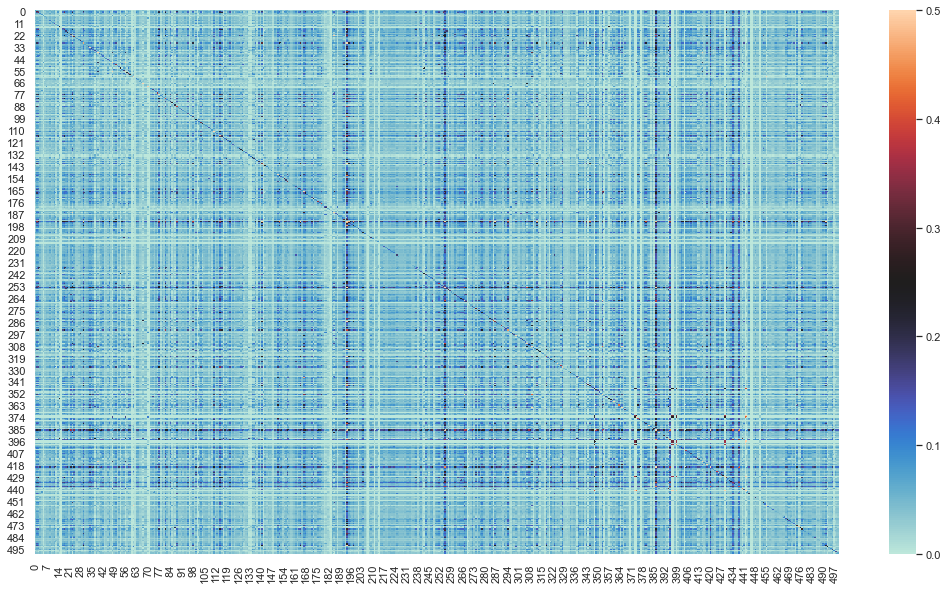

In [6]:
# Historical Variance
annualization_factor = 252
covariance_assets = annualization_factor*np.cov(returns_df.T)

print(f"matrix shape: {covariance_assets.shape}")

# Visualize the covariance matrix
import seaborn as sns

sns.set(rc = {'figure.figsize':(18,10)})
sns.heatmap(covariance_assets, cmap='icefire', vmin=0, vmax=0.5)

In [7]:
# Make sample factors
mean_factor = returns_df.mean(axis=1)
median_factor = returns_df.median(axis=1)

target_assets = returns_df.iloc[:,0] # For example

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
x = np.array([mean_factor.values, median_factor.values]).T
y = np.array(target_assets)
lr.fit(x, y)
mean_factor_exposure = lr.coef_[0]
median_factor_exposure = lr.coef_[1]

print(f"""
mean_factor exposure: {mean_factor_exposure}
median_factor exposure: {median_factor_exposure}
""")


mean_factor exposure: 0.11238107691770413
median_factor exposure: 0.9172585595616043



<AxesSubplot:>

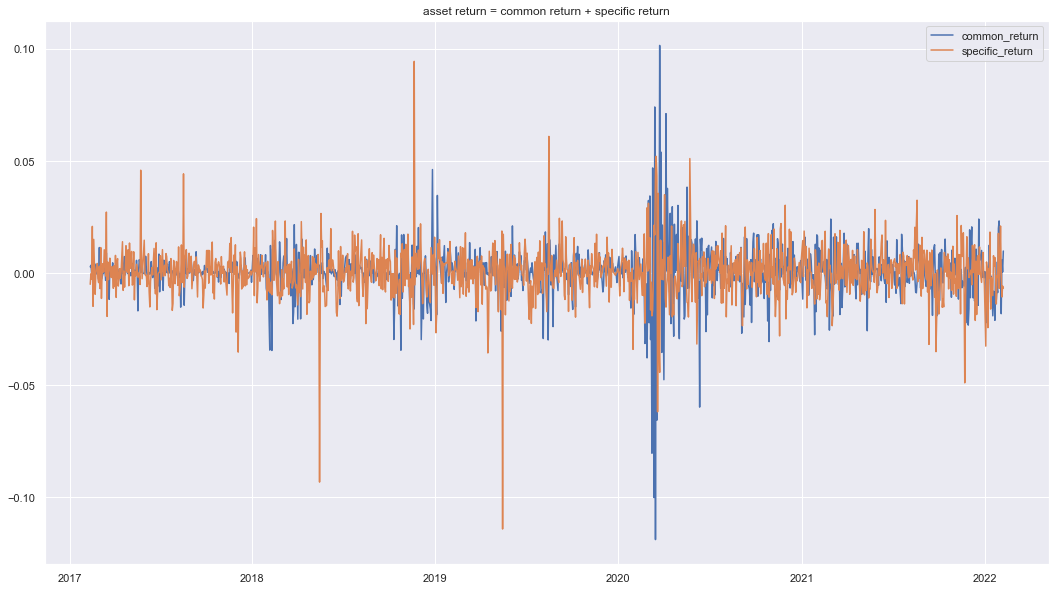

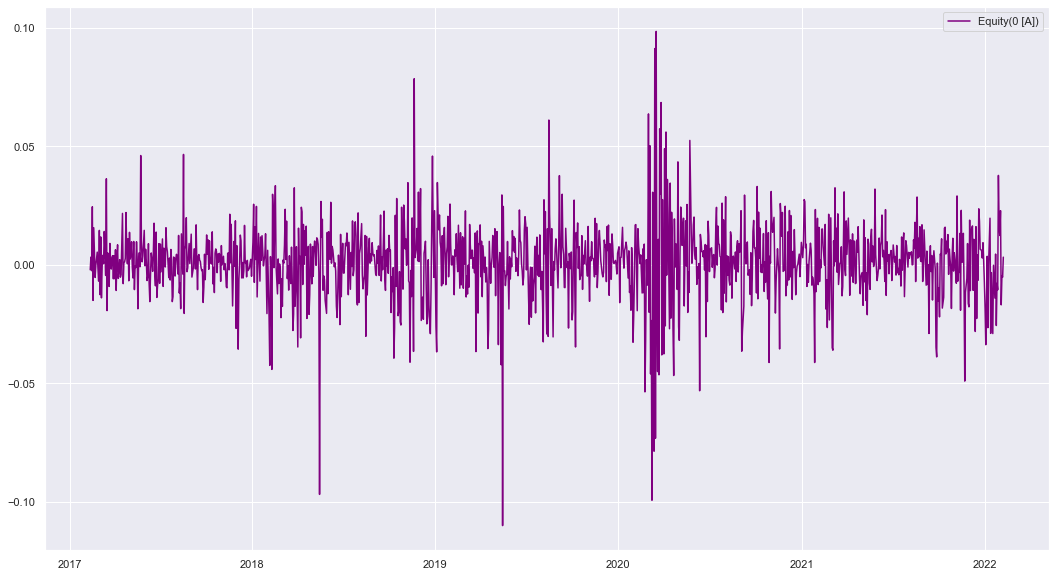

In [8]:
# Disunite systematic, specific return
# systematic return
common_return = (mean_factor_exposure * mean_factor) + (median_factor_exposure * median_factor)
common_return = common_return.rename('common_return')

# specific return
specific_return = target_assets - common_return
specific_return = specific_return.rename('specific_return')

# Visualize the common/specific returns
return_components = pd.concat([common_return, specific_return], axis=1)
return_components.plot(title='asset return = common return + specific return')
pd.DataFrame(target_assets).plot(color='purple')

In [9]:
# Factor Model of Portfolio Return
target_assets_1 = returns_df.iloc[:,0] # For example
target_assets_2 = returns_df.iloc[:,1]

asset_return_df = pd.concat([target_assets_1,target_assets_2], axis=1)
asset_return_df.head(3)

,Equity(0 [A]),Equity(1 [AA])
2017-02-10 00:00:00+00:00,-0.002186,0.023542
2017-02-13 00:00:00+00:00,0.003183,0.004684
2017-02-14 00:00:00+00:00,-0.002576,0.002084


In [10]:
# factor exposure
factor_return_l = [mean_factor, median_factor]

def get_factor_exposures(factor_return_l, asset_return_df):
    lr = LinearRegression()
    x = np.array(factor_return_l).T
    y = np.array(asset_return_df.values)
    lr.fit(x, y)
    return lr.coef_

factor_exposure_l = []
for i in range(len(asset_return_df.columns)):
    factor_exposure_l.append(
        get_factor_exposures(factor_return_l,
                             asset_return_df[asset_return_df.columns[i]]
                             ))

factor_exposure_a = np.array(factor_exposure_l)

print(f"factor_exposures for asset 1 {factor_exposure_a[0]}")
print(f"factor_exposures for asset 2 {factor_exposure_a[1]}")

factor_exposures for asset 1 [0.11238108 0.91725856]
factor_exposures for asset 2 [ 2.07502166 -0.37816265]


In [11]:
# Portfolio's factor exposures (beta)

weight_1 = 0.60 # for example
weight_2 = 0.40
weight_a = np.array([weight_1, weight_2])

# exposure to mean_factor
factor_exposure_1_1 = factor_exposure_a[0,0]
factor_exposure_2_1 = factor_exposure_a[1,0]
factor_exposure_p_1 = weight_1 * factor_exposure_1_1 + \
                        weight_2 * factor_exposure_2_1

# exposure to median_factor
factor_exposure_1_2 = factor_exposure_a[0,1]
factor_exposure_2_2 = factor_exposure_a[1,1]
factor_exposure_p_2 = weight_1 * factor_exposure_1_2 + \
                        weight_2 * factor_exposure_2_2

print(f"""
portfolio factor exposure\n
factor_1: {factor_exposure_p_1}
factor_2: {factor_exposure_p_2}
""")


portfolio factor exposure

factor_1: 0.897437308945161
factor_2: 0.3990900765387313



In [12]:
# Calculate portfolio return
asset_return_1 = asset_return_df.values[:,0]
asset_return_2 = asset_return_df.values[:,1]
portfolio_return = (weight_a[0] * asset_return_1) + \
                    (weight_a[1] * asset_return_2)

portfolio_return = pd.Series(portfolio_return,index=asset_return_df.index).rename('portfolio_return')

portfolio_return.head(3)

2017-02-10 00:00:00+00:00    0.008105
2017-02-13 00:00:00+00:00    0.003784
2017-02-14 00:00:00+00:00   -0.000712
Freq: C, Name: portfolio_return, dtype: float64

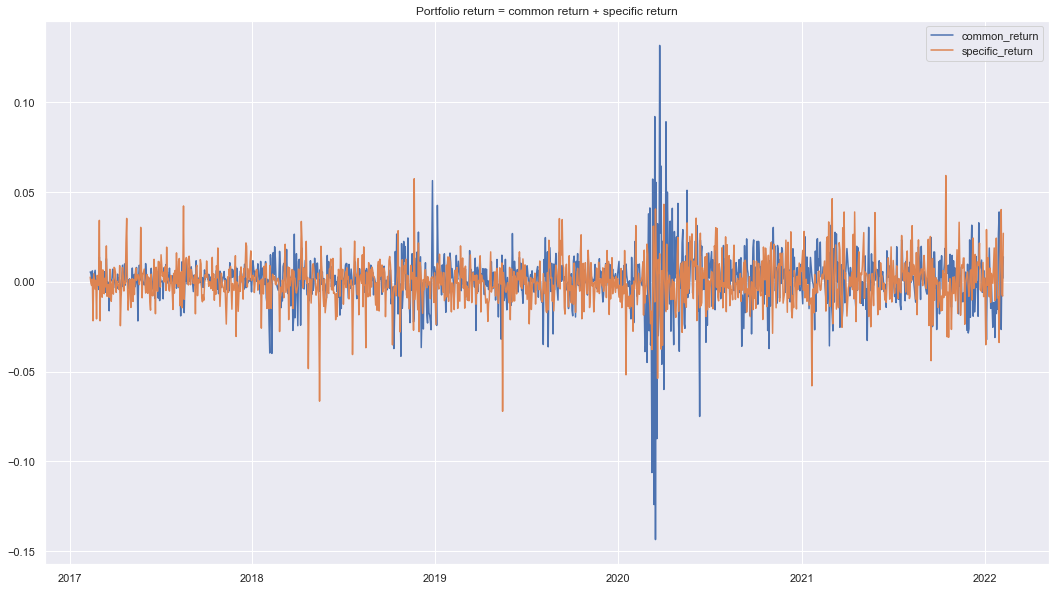

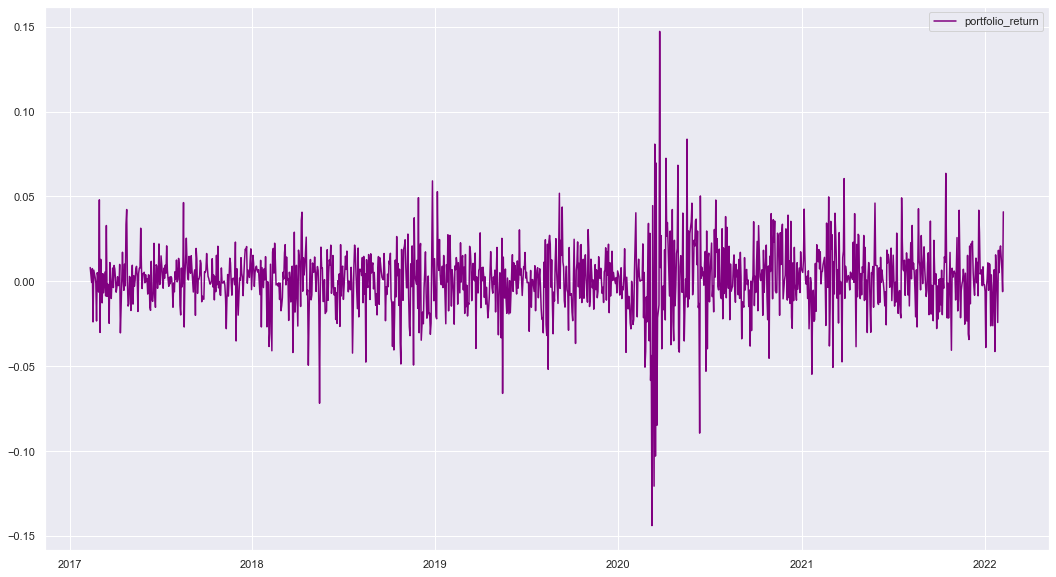

In [13]:
# Disunite systematic, specific return
# systematic return
common_return = (factor_exposure_p_1 * mean_factor) + (factor_exposure_p_2 * median_factor)
common_return = common_return.rename('common_return')

# specific return
specific_return = portfolio_return - common_return
specific_return = specific_return.rename('specific_return')

# Visualize the common return and specific return
return_components = pd.concat([common_return,specific_return],axis=1)
return_components.plot(title="Portfolio return = common return + specific return");
pd.DataFrame(portfolio_return).plot(color='purple');

## Covariance Matrix of Assets / Portfolio

Calculate the variance of stock 1.
$\textrm{Var}(f_{1}) = \beta_{1,1}^2 \textrm{Var}(f_{1}) + \beta_{1,2}^2 \textrm{Var}(f_{2}) + 2\beta_{1,1}\beta_{1,2}\textrm{Cov}(f_{1},f_{2}) + \textrm{Var}(s_{1})$

In [14]:
# Covariance Matrix of Assets
"""
asset_return_df = pd.DataFrame(assets daily return) for example 2 stocks
factor_return_l = [mean_factor, median_factor]
get_factor_exposures(factor_return_l) -> return lr.coef_
factor_exposure_a = factor_exposure list consist of assets
"""

# Variance of stock 1
common_return_1 = factor_exposure_1_1 * mean_factor + factor_exposure_1_2 * median_factor
specific_return_1 = asset_return_1 - common_return_1

covm_f1_f2 = np.cov(mean_factor, median_factor, ddof=1) # ddof: degree of freedom
var_f1 = covm_f1_f2[0,0]
var_f2 = covm_f1_f2[1,1]
cov_f1_f2 = covm_f1_f2[0,1]

# Specific variance
var_s_1 = np.var(specific_return_1, ddof=1)
var_asset_1 = (factor_exposure_1_1**2 * var_f1) + \
              (factor_exposure_1_2**2 * var_f2) + \
              2 * (factor_exposure_1_1 * factor_exposure_1_2 * cov_f1_f2) + \
              var_s_1

print(f"variance of asset 1: {var_asset_1:.8f}")

variance of asset 1: 0.00027065


In [15]:
# variance of stock 2
common_return_2 = factor_exposure_2_1 * mean_factor + factor_exposure_2_2 * median_factor
specific_return_2 = asset_return_2 - common_return_2

var_s_2 = np.var(specific_return_2,ddof=1)
var_asset_2 = (factor_exposure_2_1**2 * var_f1) + \
              (factor_exposure_2_2**2 * var_f2) + \
              (2 * factor_exposure_2_1 * factor_exposure_2_2 * cov_f1_f2) + \
              var_s_2

print(f"variance of asset 2: {var_asset_2:.8f}")

variance of asset 2: 0.00125273


### Covariance of stock 1 and stock 2 and its Matrices form

Calculate the covariance of stock 1 and 2.
$\textrm{Cov}(f_{1},f_{2}) = \beta_{1,1}\beta_{2,1}\textrm{Var}(f_{1}) + \beta_{1,1}\beta_{2,2}\textrm{Cov}(f_{1},f_{2}) + \beta_{1,2}\beta_{2,1}\textrm{Cov}(f_{1},f_{2}) + \beta_{1,2}\beta_{2,2}\textrm{Var}(f_{2})$

Create matrices $\mathbf{F}$, $\mathbf{B}$ and $\mathbf{S}$, where
$\mathbf{F}= \begin{pmatrix}
\textrm{Var}(f_1) & \textrm{Cov}(f_1,f_2) \\
\textrm{Cov}(f_2,f_1) & \textrm{Var}(f_2)
\end{pmatrix}$
is the covariance matrix of factors,

$\mathbf{B} = \begin{pmatrix}
\beta_{1,1}, \beta_{1,2}\\
\beta_{2,1}, \beta_{2,2}
\end{pmatrix}$
is the matrix of factor exposures, and

$\mathbf{S} = \begin{pmatrix}
\textrm{Var}(s_i) & 0\\
0 & \textrm{Var}(s_j)
\end{pmatrix}$
is the matrix of specific variances.

Then calculate $\mathbf{BFB}^T$

In [16]:
cov_asset_1_2 = (factor_exposure_1_1 * factor_exposure_2_1 * var_f1) + \
            (factor_exposure_1_1 * factor_exposure_2_2 * cov_f1_f2) + \
            (factor_exposure_1_2 * factor_exposure_2_1 * cov_f1_f2) + \
            (factor_exposure_1_2 * factor_exposure_2_2 * var_f2)
print(f"covariance of assets 1 and 2: {cov_asset_1_2:.8f}")
print(f"numpy cov calculation of two stocks: {np.cov(asset_return_df.T)[0,1]:.8f}")
# because of specific variance effect

covariance of assets 1 and 2: 0.00023494
numpy cov calculation of two stocks: 0.00019292


In [17]:
# Matrix form
F = covm_f1_f2
B = factor_exposure_a
S = np.diag([var_s_1, var_s_2])

covm_assets = B.dot(F).dot(B.T) + S
print(f"covariance matrix of assets 1 and 2 \n{covm_assets}")

covariance matrix of assets 1 and 2 
[[0.00027065 0.00023494]
 [0.00023494 0.00125273]]


### Portfolio variance
$\textrm{Var}(r_p) = x_{1}^{2} \textrm{Var}(r_1) + x_{2}^{2} \textrm{Var}(r_2) + 2x_{1}x_{2}\textrm{Cov}(r_{1},r_{2})  $
$\mathbf{X}^T(\mathbf{BFB}^T + \mathbf{S})\mathbf{X}$

In [18]:
weight_1 = 0.60
weight_2 = 0.40

# TODO: calculate portfolio variance
var_portfolio = weight_1**2 * var_asset_1 + \
                weight_2**2 * var_asset_2 + \
                2*weight_1*weight_2*cov_asset_1_2
print(f"variance of portfolio is {var_portfolio:.8f}")

variance of portfolio is 0.00041064


In [19]:
# Matrix form
X = np.array([weight_1, weight_2]).reshape(2,1)
var_portfolio = X.T.dot(B.dot(F).dot(B.T) + S).dot(X)
print(f"portfolio variance is \n{var_portfolio[0][0]:.8f}")

portfolio variance is 
0.00041064


# PCA

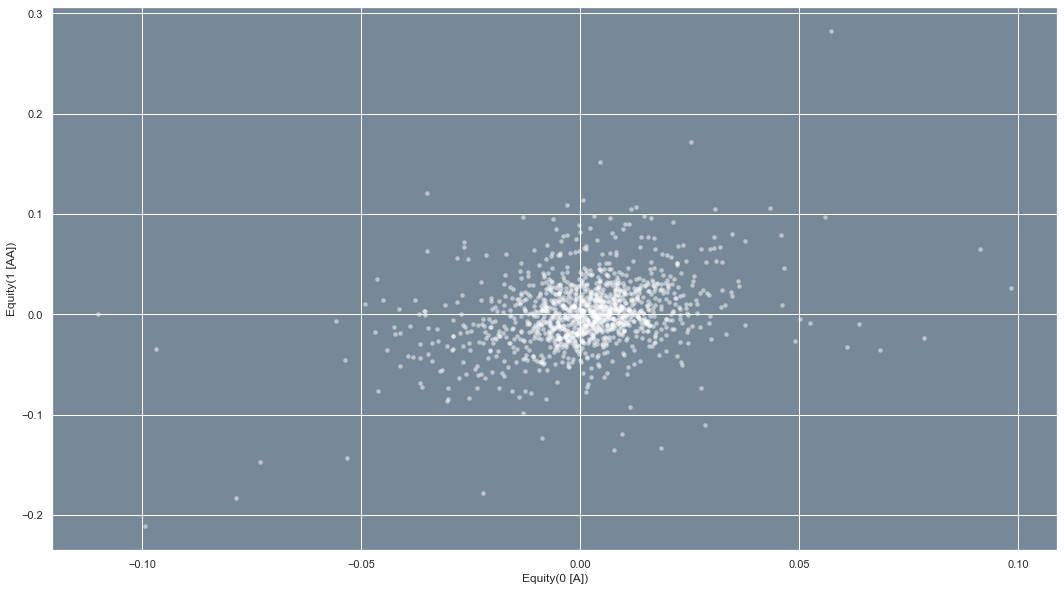

In [20]:
ax = returns_df.plot.scatter(x = 0, y = 1, grid = True, color = 'white', alpha = 0.5, linewidth = 0)
ax.set_facecolor('lightslategray')

In [21]:
returns_df.corr(method='pearson').head()

,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABNB]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ACWI]),Equity(9 [ADBE]),...,Equity(490 [XME]),Equity(491 [XOM]),Equity(492 [XOP]),Equity(493 [XPEV]),Equity(494 [YUM]),Equity(495 [ZBH]),Equity(496 [ZEN]),Equity(497 [ZIM]),Equity(498 [ZNGA]),Equity(499 [ZTS])
Equity(0 [A]),1.000000,0.331325,0.287702,0.536520,0.428426,0.082053,0.614545,0.607787,0.714835,0.586055,...,0.450242,0.370080,0.351632,0.126827,0.407419,0.427284,0.461665,0.097278,0.311399,0.616689
Equity(1 [AA]),0.331325,1.000000,0.489578,0.321990,0.222677,0.056521,0.219269,0.393561,0.551983,0.234025,...,0.763714,0.564890,0.594185,0.081689,0.349506,0.386922,0.236789,0.149634,0.096339,0.262250
Equity(2 [AAL]),0.287702,0.489578,1.000000,0.254988,0.178928,0.112433,0.183916,0.310905,0.462734,0.176428,...,0.500549,0.451868,0.450472,0.070244,0.374409,0.410978,0.189603,0.080070,0.009184,0.221821
Equity(3 [AAPL]),0.536520,0.321990,0.254988,1.000000,0.365619,0.107459,0.511756,0.584437,0.735514,0.652607,...,0.428107,0.349098,0.367083,0.123159,0.401468,0.367230,0.468703,0.045884,0.328817,0.542747
Equity(4 [ABBV]),0.428426,0.222677,0.178928,0.365619,1.000000,-0.003121,0.471024,0.452484,0.514096,0.376056,...,0.292978,0.346852,0.301147,0.032292,0.310016,0.356493,0.305121,-0.007384,0.235428,0.450138


In [22]:
from sklearn.decomposition import PCA

def get_num_components(df, var_ret):
    if var_ret > 1 or var_ret < 0:
        print('error')
        return 0

    if var_ret == 1:
        return df.shape[1]

    pca = PCA(n_components=df.shape[1])
    pca.fit(df)

    needed_components = 0
    var_sum = 0

    for i in range(0, df.shape[1]):
        if var_sum >= var_ret:
            print('Total Variance Retained: ', pca.explained_variance_ratio_[0:needed_components].sum())
            return needed_components
        else:
            needed_components += 1
            var_sum += pca.explained_variance_ratio_[i]

num_components = get_num_components(returns_df, 0.9)
print('\nNumber of Principal Components Needed: ', num_components)

# Calculate the percentage of dimensionality reduction
red_per = ((returns_df.shape[1] - num_components) / returns_df.shape[1]) * 100

print('We were able to reduce the dimentionality of the data by:', red_per, 'percent')

Total Variance Retained:  0.9008886713169784

Number of Principal Components Needed:  74
We were able to reduce the dimentionality of the data by: 85.2 percent


### PCA as a Factor Model

$$
\textbf{r} = \textbf{B}\textbf{f} + \textbf{s}
$$

where $\textbf{r}$ is a matrix containing the asset returns, $\textbf{B}$ is a matrix representing the factor exposures, $\textbf{f}$ is the matrix of factor returns, and $\textbf{s}$ is the idiosyncratic risk (also known as the company specific risk).

In this notebook, we will use real stock data to calculate:

* The Factor Exposures (Factor Betas) $\textbf{B}$
* The Factor Returns $\textbf{f}$
* The Idiosyncratic Risk Matrix $\textbf{S}$
* The Factor Covariance Matrix $\textbf{F}$

In [23]:
# Factor Exposures

def factor_betas(pca, factor_beta_indices, factor_beta_columns):

    assert len(factor_beta_columns.shape) == 1
    assert len(factor_beta_indices.shape) == 1

    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

def factor_returns(pca, returns, factor_return_indices, factor_return_columns):

    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1

    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):

    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals_ = (returns - common_returns_)

    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

def factor_cov_matrix(factor_returns, ann_factor):

    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

def fit_pca(returns, num_factor_exposures, svd_solver):

    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)

    return pca

In [24]:
class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures, pca):

        self.factor_betas_ = factor_betas(pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = factor_returns(pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = factor_cov_matrix(self.factor_returns_, ann_factor)
        self.idiosyncratic_var_matrix_ = idiosyncratic_var_matrix(returns, self.factor_returns_, self.factor_betas_, ann_factor)

ann_factor = 252
num_factor_exposures = 20
svd_solver = 'full'
pca = fit_pca(returns_df, num_factor_exposures, svd_solver)

rm = RiskModel(returns_df, ann_factor, num_factor_exposures, pca)

In [25]:
# Print detail
# rm.factor_betas_
# rm.factor_returns_
# rm.idiosyncratic_var_matrix_
# rm.factor_cov_matrix_

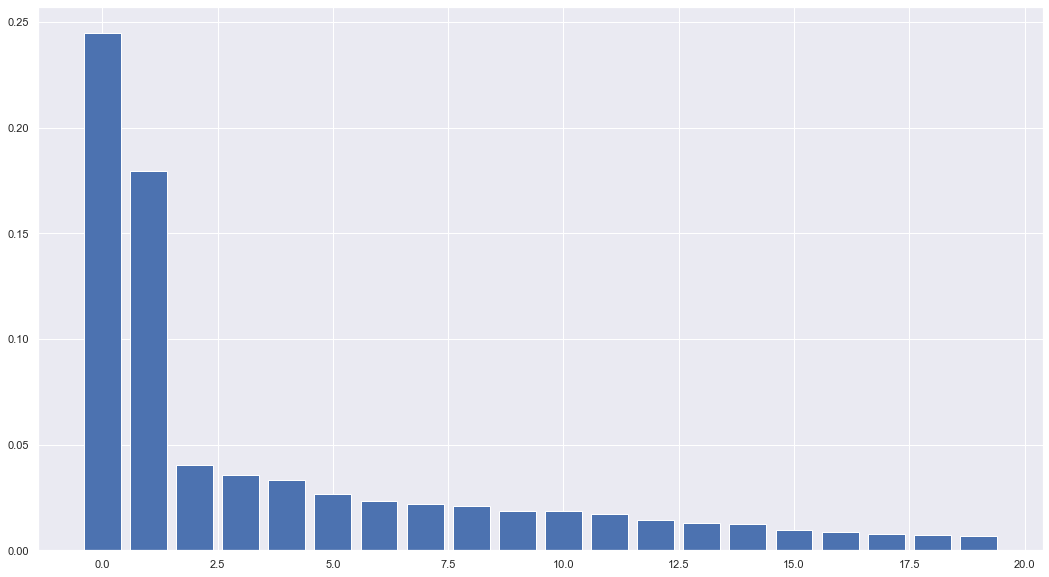

In [26]:
# View The Percent of Variance Explained by Each Factor
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);

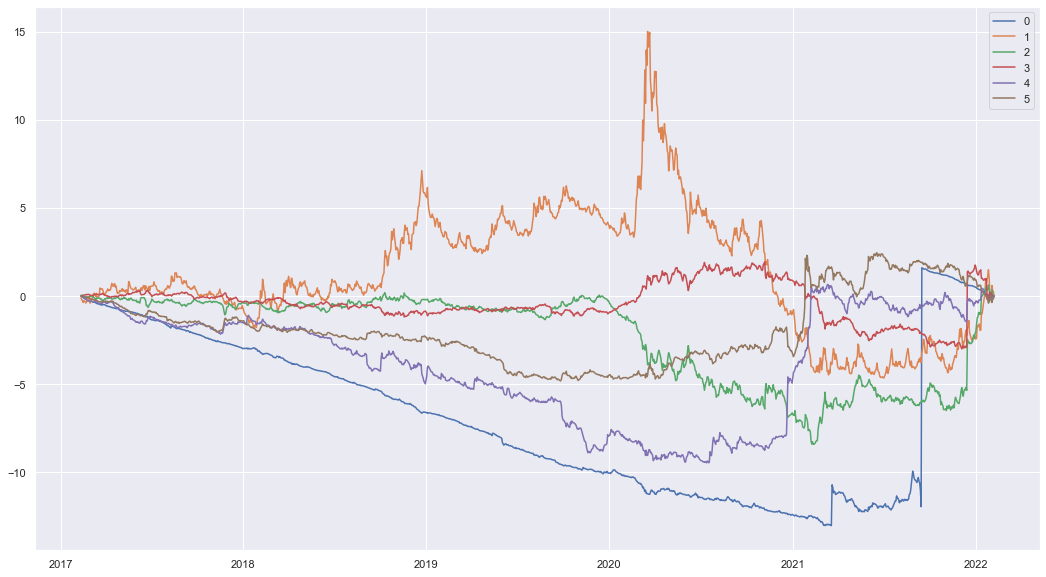

In [27]:
# View the Factor Returns
rm.factor_returns_.loc[:,0:5].cumsum().plot();

# Alpha Factor

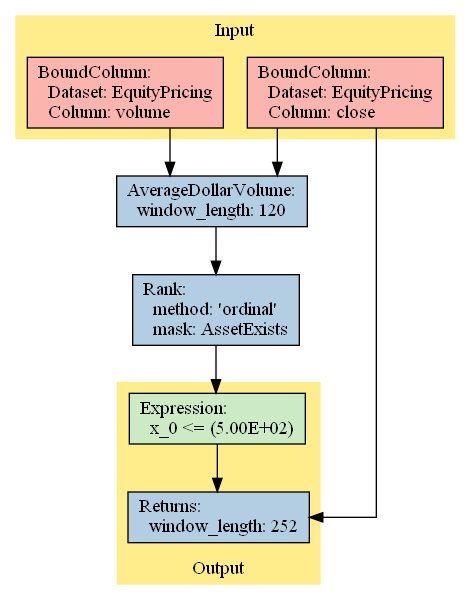

In [28]:
# Create an Alpha factor based on momentum. for example
from zipline.pipeline.factors import Returns

factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
p1 = Pipeline(screen=universe)
rets1 = Returns(window_length=252, mask=universe)
p1.add(rets1,"1YearReturns")
df1 = engine.run_pipeline(p1, factor_start_date, universe_end_date)

p1.show_graph(format='png')

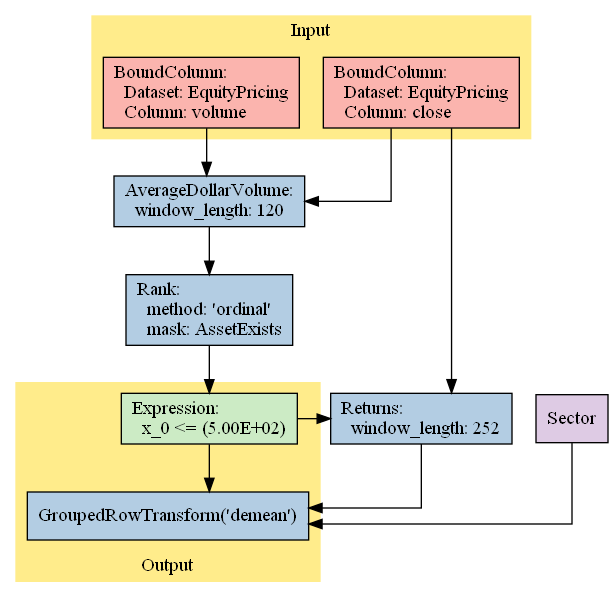

In [29]:
# Sector demean
p2 = Pipeline(screen=universe)
factor_demean_by_sector = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()))
p2.add(factor_demean_by_sector, 'Momentum_1YR_demean_by_sector')
df2 = engine.run_pipeline(p2, factor_start_date, universe_end_date)

p2.show_graph(format='png')

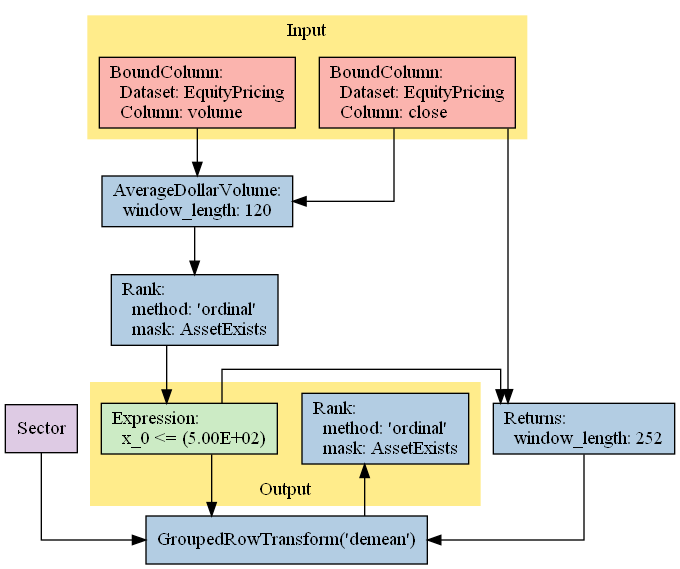

In [30]:
# Sector demean and ranked
p3 = Pipeline(screen=universe)
factor1 = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()).rank())
p3.add(factor1, 'Momentum_1YR_demean_by_sector_ranked')
df3 = engine.run_pipeline(p3, factor_start_date, universe_end_date)

p3.show_graph(format='png')

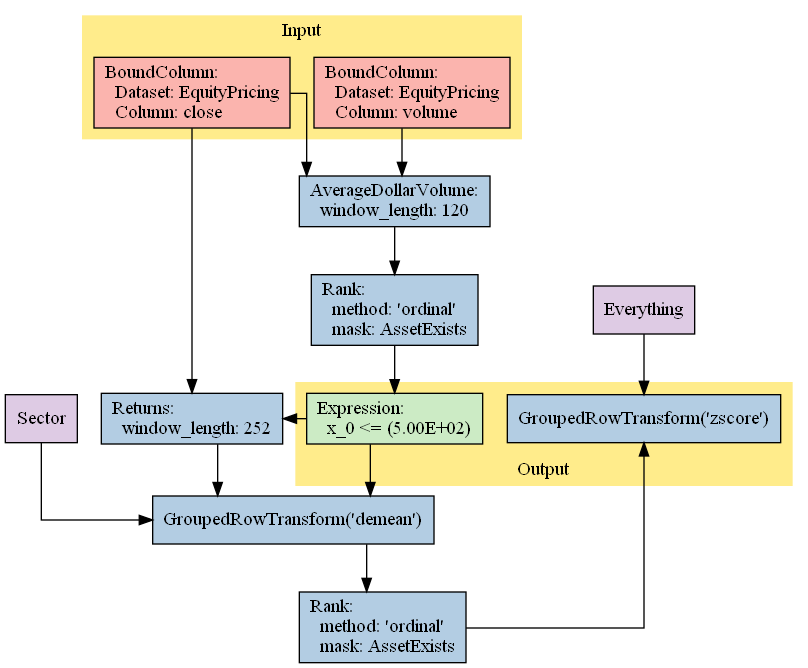

In [31]:
# Sector demean and ranked and z-score
p4 = Pipeline(screen=universe)
factor2 = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()).rank().zscore())
p4.add(factor2, 'Momentum_1YR_demean_by_sector_ranked_zscore')
df4 = engine.run_pipeline(p4, factor_start_date, universe_end_date)

p4.show_graph(format='png')

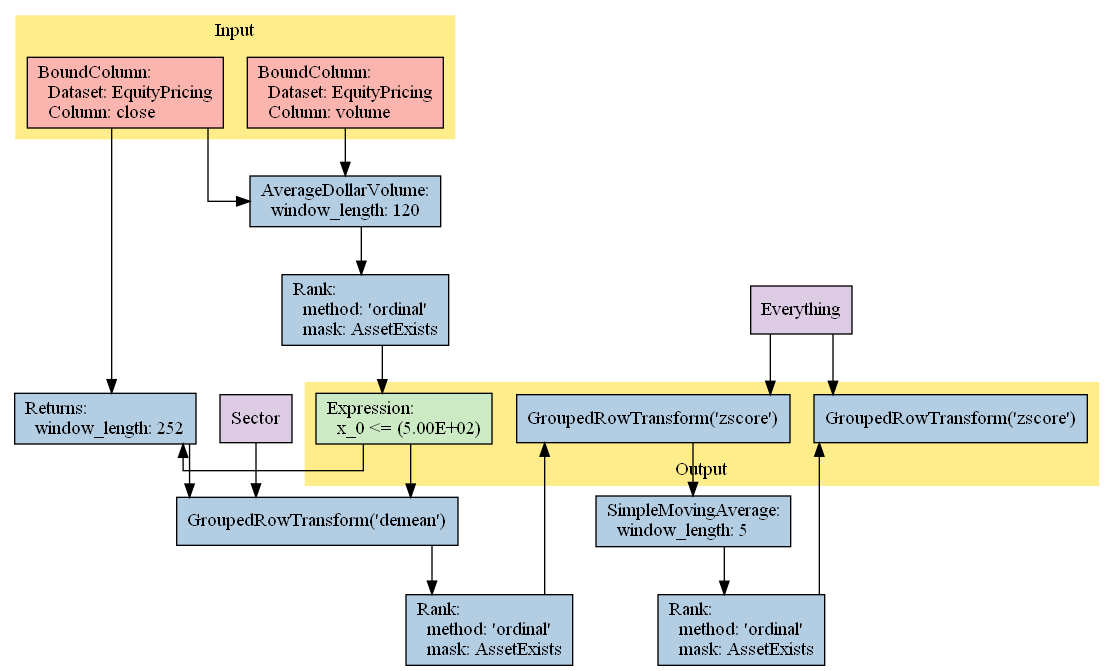

In [35]:
# Smoothing
from zipline.pipeline.factors import SimpleMovingAverage

p5 = Pipeline(screen=universe)

factor_smoothed = (
    SimpleMovingAverage(inputs=[factor2], window_length=5).
    rank().zscore()
)

p5.add(factor2, 'Momentum_Factor')
p5.add(factor_smoothed, 'Smoothed_Momentum_Factor')
df5 = engine.run_pipeline(p5, factor_start_date, universe_end_date)

p5.show_graph(format='png')

<class 'zipline.assets._assets.Equity'>
Equity(3 [AAPL])


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_core.py:394: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_core.py:394: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


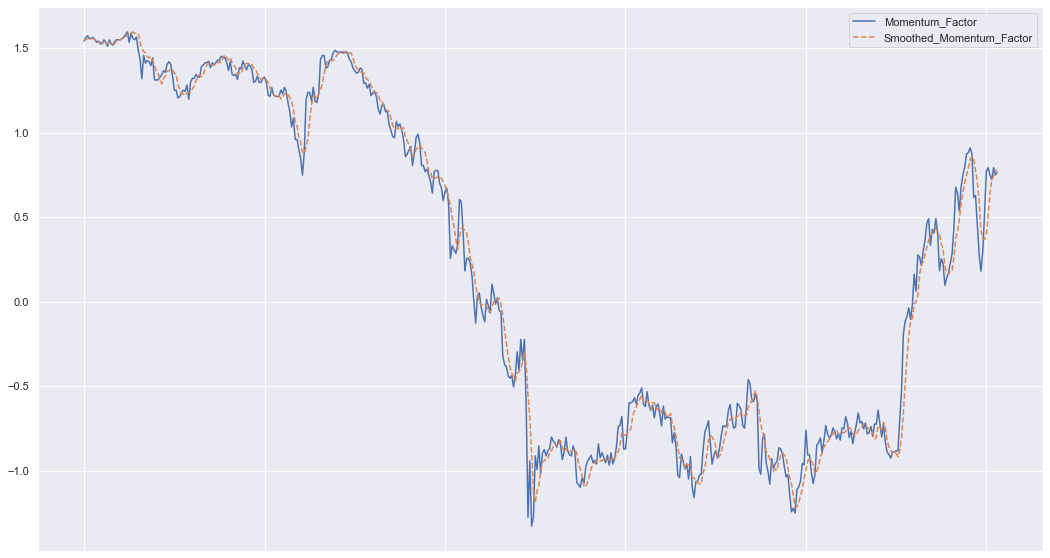

In [48]:
# Get the level value for a assets for example AAPL
stock_index_name = df5.index.get_level_values(1)[3]

print(type(stock_index_name))
print(stock_index_name)

single_stock_df = df5[np.in1d(df5.index.get_level_values(1), [stock_index_name])]

single_stock_df['Momentum_Factor'].plot()
single_stock_df['Smoothed_Momentum_Factor'].plot(style='--')
plt.legend()

In [54]:
# Factor and forward returns: Evaluate Factors
import alphalens as al

# get list of stocks in our portfolio
assets = df5.index.levels[1].values.tolist() # which may be a subset of the original universe
print(f"stock universe number of stocks {len(universe_tickers)}, and number of stocks for which we have factor values {len(assets)}")

stock universe number of stocks 500, and number of stocks for which we have factor values 500


In [60]:
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date,
        universe_end_date)

pricing.head()

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: offset is deprecated. Use freq instead
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: offset is deprecated. Use freq instead


,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABNB]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ACWI]),Equity(9 [ADBE]),...,Equity(490 [XME]),Equity(491 [XOM]),Equity(492 [XOP]),Equity(493 [XPEV]),Equity(494 [YUM]),Equity(495 [ZBH]),Equity(496 [ZEN]),Equity(497 [ZIM]),Equity(498 [ZNGA]),Equity(499 [ZTS])
2020-02-07 00:00:00+00:00,82.057,15.516,28.38,78.923,84.574,NaN,85.551,207.103,78.527,366.09,...,25.556,54.347,73.950,NaN,98.854,154.153,86.95,NaN,6.65,137.551
2020-02-10 00:00:00+00:00,83.300,15.386,28.79,79.298,86.828,NaN,85.970,208.052,78.917,370.00,...,25.517,53.773,72.102,NaN,99.658,155.957,89.20,NaN,6.79,141.165
2020-02-11 00:00:00+00:00,83.951,15.706,29.84,78.819,87.974,NaN,86.817,207.651,79.318,369.28,...,25.811,54.284,72.448,NaN,100.801,157.012,88.54,NaN,6.74,142.631
2020-02-12 00:00:00+00:00,84.287,15.726,30.47,80.691,89.614,NaN,86.447,207.504,79.846,374.29,...,25.556,54.948,73.411,NaN,102.051,156.430,88.88,NaN,6.75,141.591
2020-02-13 00:00:00+00:00,84.326,15.716,30.09,80.117,87.378,NaN,86.340,207.906,79.484,374.84,...,25.527,54.643,72.949,NaN,102.206,156.460,89.53,NaN,6.92,143.532


In [61]:
# Compare to the factor data for a single stock
stock_index_name = df5.index.get_level_values(1)[3] #just pick a stock; in this case, stock is AAPL
single_stock_factor_df = df5[np.in1d(df5.index.get_level_values(1), [stock_index_name])]

single_stock_factor_df.head()

,,Momentum_Factor,Smoothed_Momentum_Factor
2020-02-06 00:00:00+00:00,Equity(3 [AAPL]),1.542188,1.549937
2020-02-07 00:00:00+00:00,Equity(3 [AAPL]),1.565437,1.549937
2020-02-10 00:00:00+00:00,Equity(3 [AAPL]),1.573187,1.557687
2020-02-11 00:00:00+00:00,Equity(3 [AAPL]),1.557687,1.557687
2020-02-12 00:00:00+00:00,Equity(3 [AAPL]),1.557687,1.557687


In [68]:
factor_names = df5.columns
print(f"The factor names are {factor_names}")

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    # TODO: get clean factor and forward returns for each factor
    # Choose single period returns (daily returns)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=df5[factor_name],
        prices=pricing,
        periods=[20])

cleaned_smooth_factor = factor_data[factor_names[1]]
cleaned_smooth_factor.head()

The factor names are Index(['Momentum_Factor', 'Smoothed_Momentum_Factor'], dtype='object')
Formatting factor data for: Momentum_Factor
Dropped 8.3% entries from factor data: 8.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_Factor
Dropped 8.3% entries from factor data: 8.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


20D    factor  \
date                      asset                                  
2020-02-07 00:00:00+00:00 Equity(0 [A])    -0.149335 -0.906713   
                          Equity(1 [AA])   -0.441158 -1.666183   
                          Equity(2 [AAL])  -0.480268 -1.472441   
                          Equity(3 [AAPL]) -0.168291  1.565437   
                          Equity(4 [ABBV]) -0.076064 -0.650974   

                                            factor_quantile  
date                      asset                              
2020-02-07 00:00:00+00:00 Equity(0 [A])                   2  
                          Equity(1 [AA])                  1  
                          Equity(2 [AAL])                 1  
                          Equity(3 [AAPL])                5  
                          Equity(4 [ABBV])                2

Returns Analysis


,20D
Ann. alpha,0.016
beta,0.007
Mean Period Wise Return Top Quantile (bps),119.538
Mean Period Wise Return Bottom Quantile (bps),42.065
Mean Period Wise Spread (bps),77.474


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\core\indexes\datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 

<Figure size 1296x720 with 0 Axes>

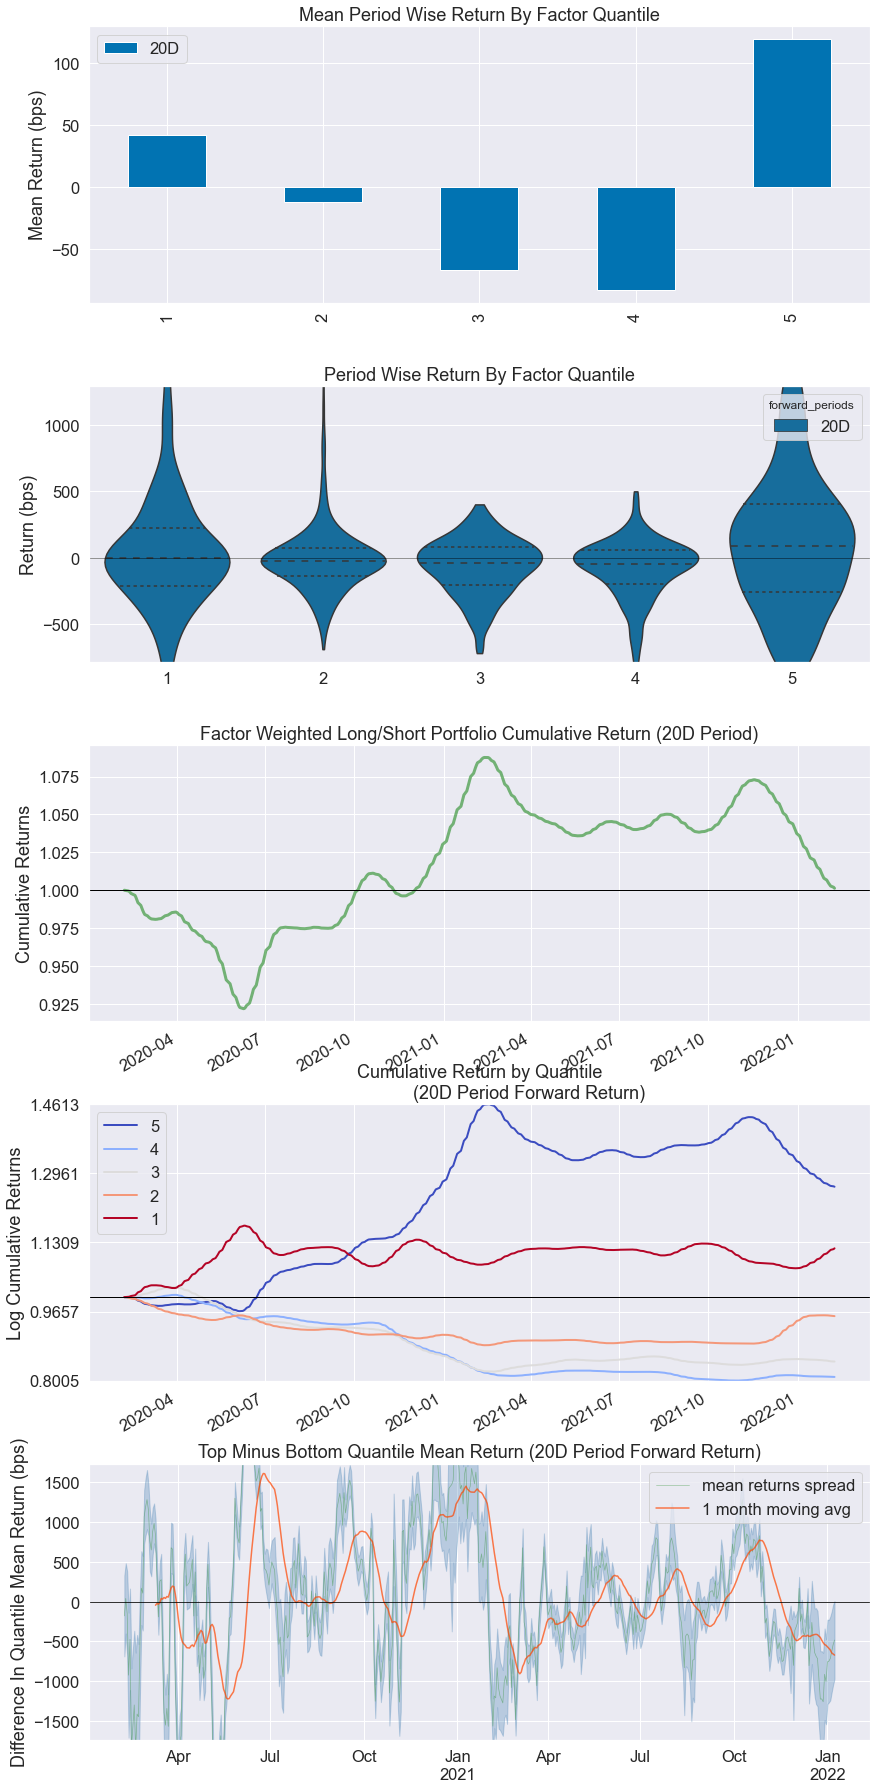

In [69]:
al.tears.create_returns_tear_sheet(cleaned_smooth_factor)

Information Analysis


,20D
IC Mean,0.013
IC Std.,0.200
Risk-Adjusted IC,0.066
t-stat(IC),1.456
p-value(IC),0.146
IC Skew,0.141
IC Kurtosis,0.428


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<Figure size 1296x720 with 0 Axes>

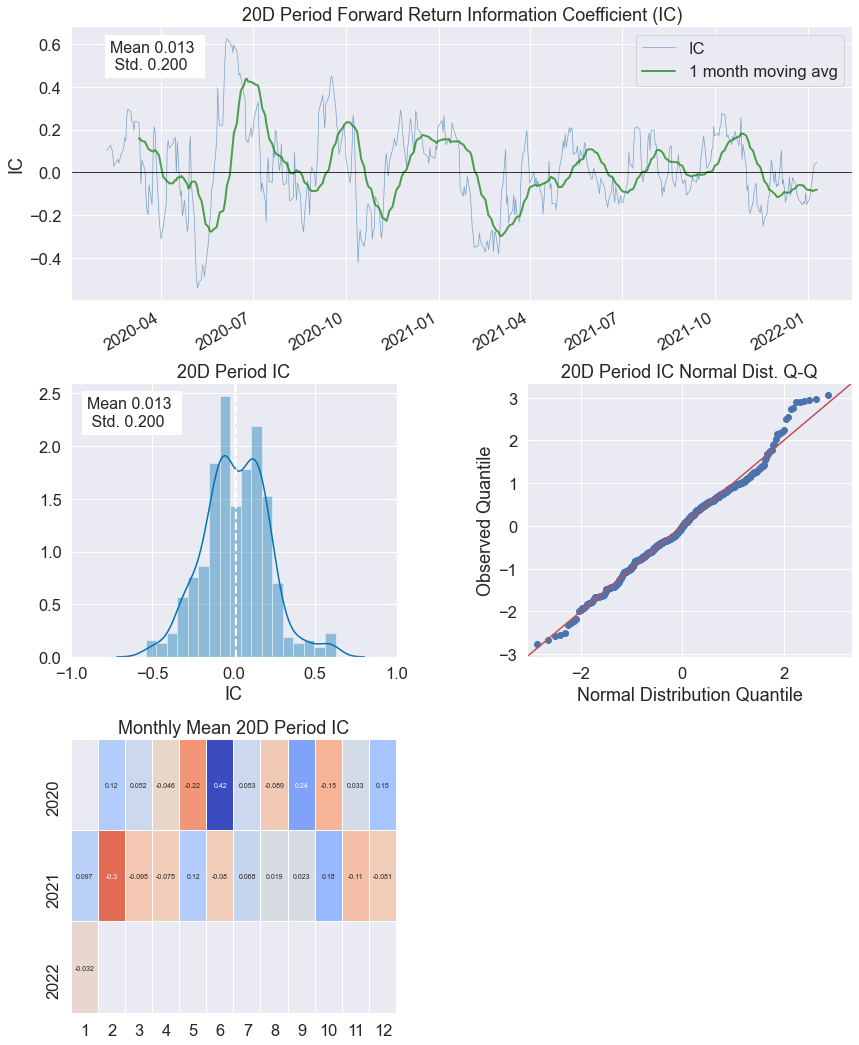

In [70]:
al.tears.create_information_tear_sheet(cleaned_smooth_factor)

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\core\indexes\datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,20D
Quantile 1 Mean Turnover,0.223
Quantile 2 Mean Turnover,0.431
Quantile 3 Mean Turnover,0.439
Quantile 4 Mean Turnover,0.388
Quantile 5 Mean Turnover,0.204


,20D
Mean Factor Rank Autocorrelation,0.904


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_to

<Figure size 1296x720 with 0 Axes>

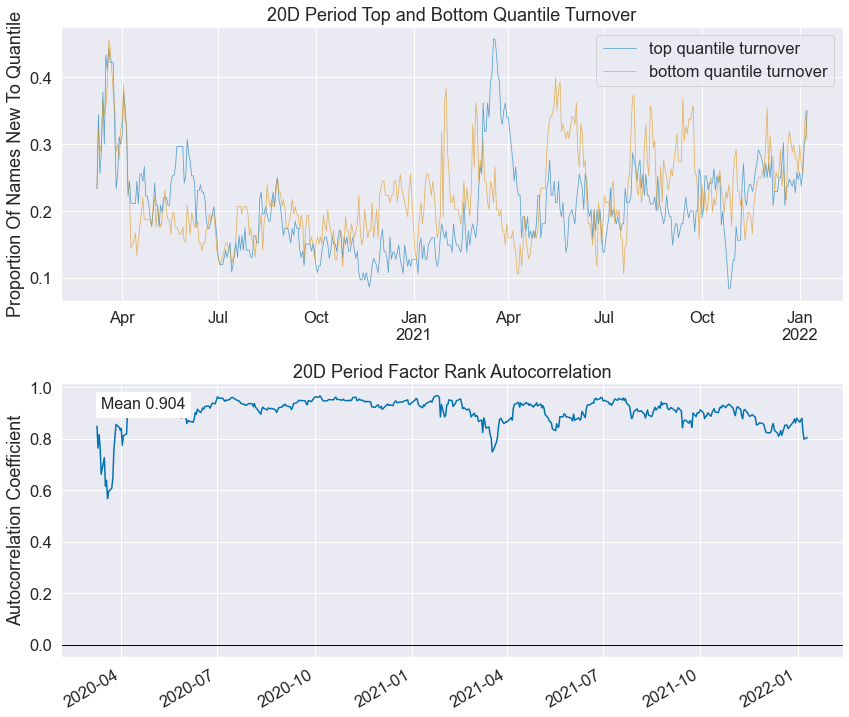

In [71]:
al.tears.create_turnover_tear_sheet(cleaned_smooth_factor)

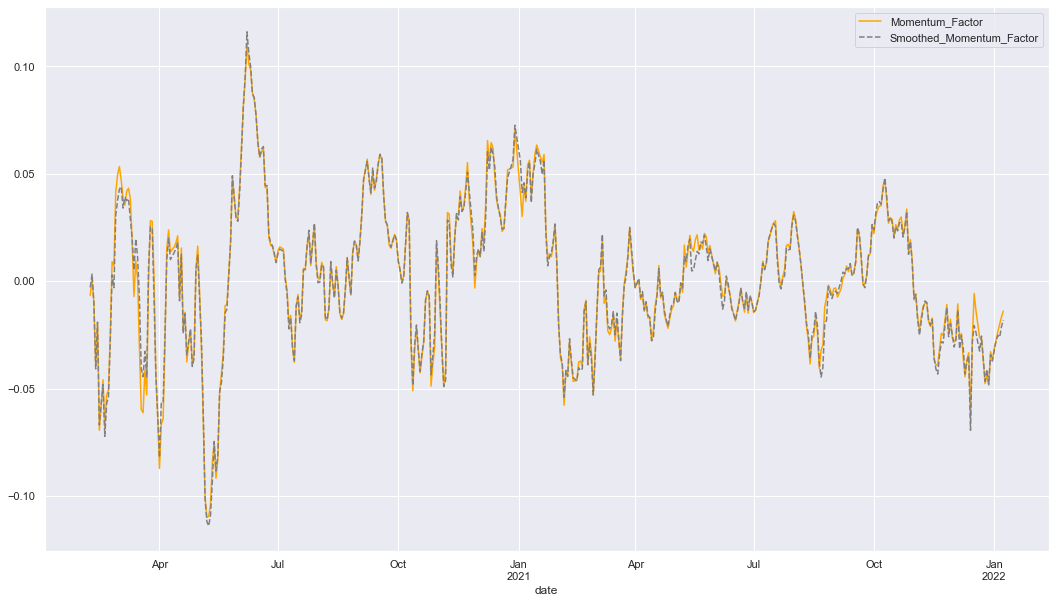

In [73]:
# Factor returns
ls_factor_return = []

for i, factor_name in enumerate(factor_names):

    factor_return = al.performance.factor_returns(factor_data[factor_name])
    factor_return.columns = [factor_name]
    ls_factor_return.append(factor_return)

unsmoothed_factor_return = ls_factor_return[0]
smoothed_factor_return = ls_factor_return[1]

unsmoothed_factor_return['Momentum_Factor'].plot(color='orange')
smoothed_factor_return['Smoothed_Momentum_Factor'].plot(color='gray',style='--');
plt.legend()

In [75]:
# Sharpe ratio

def sharpe_ratio(df, frequency="daily"):

    if frequency == "daily":
        # TODO: daily to annual conversion
        annualization_factor = np.sqrt(252)
    elif frequency == "monthly":
        #TODO: monthly to annual conversion
        annualization_factor = np.sqrt(12)
    else:
        # TODO: no conversion
        annualization_factor = 1

    #TODO: calculate the sharpe ratio and store it in a dataframe.
    # name the column 'Sharpe Ratio'.
    # round the numbers to 2 decimal places
    df_sharpe = pd.DataFrame(data=annualization_factor*df.mean()/df.std(),
     columns=['Sharpe Ratio']).round(2)

    return df_sharpe

print(sharpe_ratio(ls_factor_return[0]).iloc[0])
print(sharpe_ratio(ls_factor_return[1]).iloc[0])

Sharpe Ratio    0.68
Name: Momentum_Factor, dtype: float64
Sharpe Ratio    0.53
Name: Smoothed_Momentum_Factor, dtype: float64


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:title={'center':'rank IC'}, xlabel='date'>

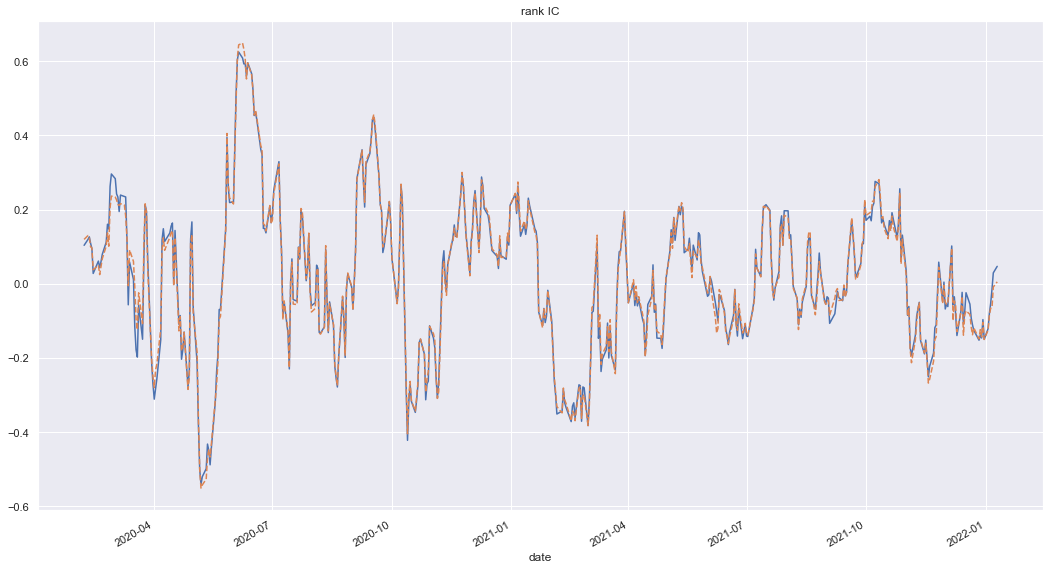

In [76]:
# Rank IC

ls_rank_ic = []

for i, factor_name in enumerate(factor_names):
    rank_ic = al.performance.factor_information_coefficient(factor_data[factor_name])
    rank_ic.columns = [factor_name]
    ls_rank_ic.append(rank_ic)

ls_rank_ic[0]['Momentum_Factor'].plot(title="rank IC")
ls_rank_ic[1]['Smoothed_Momentum_Factor'].plot(style='--')